## 초반 준비
### 필요 packages import & install

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
pip install vaderSentiment

     |████████████████████████████████| 133kB 6.5MB/s 


In [ ]:
import re
import pandas as pd
import numpy as np
from collections import defaultdict

# Set Pandas to display all rows of dataframes
pd.set_option('display.max_rows', 500)

# nltk
from nltk import tokenize

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Plotting tools
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('fivethirtyeight')
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from tqdm import tqdm_notebook as tqdm
from tqdm import trange

##데이터 정리
###초기 데이터프레임 생성
df: ['date' (year), 'president', 'transcript', 'sentiments' (all initialized to 0.0)]

In [21]:
import pandas as pd
url = 'https://raw.githubusercontent.com/BrianWeinstein/state-of-the-union/master/transcripts.csv'
df = pd.read_csv(url, error_bad_lines=False)
del df["title"]
del df["url"]
df['sentiments']=0.0
df['date'] = pd.DatetimeIndex(df['date']).year

df.head(10)

,date,president,transcript,sentiments
0,2018,Donald J. Trump,"\nMr. Speaker, Mr. Vice President, Members of ...",0.0
1,2017,Donald J. Trump,"Thank you very much. Mr. Speaker, Mr. Vice Pre...",0.0
2,2016,Barack Obama,"Thank you. Mr. Speaker, Mr. Vice President, Me...",0.0
3,2015,Barack Obama,"The President. Mr. Speaker, Mr. Vice President...",0.0
4,2014,Barack Obama,"The President. Mr. Speaker, Mr. Vice President...",0.0
5,2013,Barack Obama,"Please, everybody, have a seat. Mr. Speaker, M...",0.0
6,2012,Barack Obama,"Mr. Speaker, Mr. Vice President, Members of Co...",0.0
7,2011,Barack Obama,"Mr. Speaker, Mr. Vice President, Members of Co...",0.0
8,2010,Barack Obama,"Madam Speaker, Vice President Biden, Members o...",0.0
9,2009,Barack Obama,"Madam Speaker, Mr. Vice President, Members of ...",0.0


###Sentiment 계산
sentence를 tokenize하여 vaderSentiment의 compound부분 sentiment 점수를 각각 구해 평균을 구한다

In [ ]:
analyzer = SentimentIntensityAnalyzer()

In [25]:
for ind in tqdm(df.index, desc='Progress'):
     text = df['transcript'][ind]
     sentence_list = tokenize.sent_tokenize(text)
     sentiment = 0.0
     
     for sentence in sentence_list:
         vs = analyzer.polarity_scores(sentence)
         sentiment += vs['compound']
            
     sentiment = sentiment / len(sentence_list)

     df.at[ind,'sentiments'] = sentiment
     

In [26]:
df.head(10)

,date,president,transcript,sentiments
0,2018,Donald J. Trump,"\nMr. Speaker, Mr. Vice President, Members of ...",0.119823
1,2017,Donald J. Trump,"Thank you very much. Mr. Speaker, Mr. Vice Pre...",0.202572
2,2016,Barack Obama,"Thank you. Mr. Speaker, Mr. Vice President, Me...",0.139046
3,2015,Barack Obama,"The President. Mr. Speaker, Mr. Vice President...",0.194940
4,2014,Barack Obama,"The President. Mr. Speaker, Mr. Vice President...",0.207133
5,2013,Barack Obama,"Please, everybody, have a seat. Mr. Speaker, M...",0.190326
6,2012,Barack Obama,"Mr. Speaker, Mr. Vice President, Members of Co...",0.131801
7,2011,Barack Obama,"Mr. Speaker, Mr. Vice President, Members of Co...",0.193616
8,2010,Barack Obama,"Madam Speaker, Vice President Biden, Members o...",0.095411
9,2009,Barack Obama,"Madam Speaker, Mr. Vice President, Members of ...",0.112709


###최종 데이터프레임 생성
기존 df에 transcrpit 제거 후 동일 년도 gdp growth를 붙인다

df_final:['date', 'president', 'sentiments', 'gdp_growth']

In [ ]:
df_final = df[['date', 'president', 'sentiments']].copy()
df_final.drop_duplicates(subset = 'date', keep = 'first', inplace = True)

In [ ]:
df_gdp = pd.read_csv("./USGDP_1791-2018.csv")

In [ ]:
df_final['gdp_growth'] = df_final.date.map(df_gdp.set_index('Year')['GDP Growth rate'])

In [23]:
df_final.head(10)

,date,president,sentiments,gdp_growth
0,2018,Donald J. Trump,0.119823,0.029274
1,2017,Donald J. Trump,0.202572,0.023698
2,2016,Barack Obama,0.139046,0.016381
3,2015,Barack Obama,0.194940,0.029080
4,2014,Barack Obama,0.207133,0.025256
5,2013,Barack Obama,0.190326,0.018423
6,2012,Barack Obama,0.131801,0.022493
7,2011,Barack Obama,0.193616,0.015508
8,2010,Barack Obama,0.095411,0.025643
9,2009,Barack Obama,0.112709,-0.025371


##결과
###데이터 시각화
각 대통령별로 다른 색으로 매 해 연설의 sentiment 를 나타내는 끊긴 실선 그래프와 그 대통령의 임기동안 매 해 gdp 변화율을 나타내는 실선


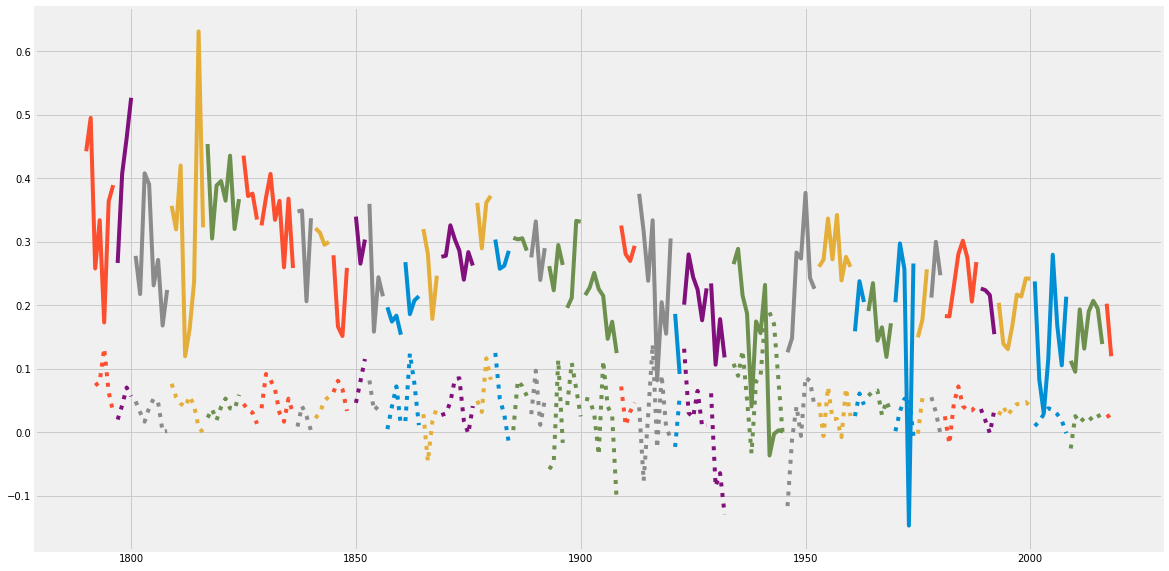

In [ ]:
import matplotlib.ticker as ticker
plt.rcParams["figure.figsize"] = (18,10)

df_graph1 = df_final[['date', 'president', 'sentiments']].copy()
df_graph2 = df_final[['date', 'president', 'gdp_growth']].copy()

plt.plot(df_graph1.pivot(index='date', columns='president'))
plt.plot(df_graph2.pivot(index='date', columns='president'),linestyle=':')


plt.show()

###전체 correlation

In [ ]:
column_1 = df_final['sentiments']
column_2 = df_final['gdp_growth']
correlation = column_1.corr(column_2)
print(correlation   )

0.10883807821741594


###각 대통령 별로 sentiment와 gdp growth correlation 정리

df_president_sentiment: ['president', 'correlation']

In [ ]:
president_names = df_final.president.unique()

df_president_sentiment = pd.DataFrame(columns=['president','correlation'])
j=0

for n in president_names:
    df_temp = pd.DataFrame(columns=['president', 'sentiments', 'gdp_growth'])
    i=0
    for ind in df_final.index:
        if df_final['president'][ind] is n:
            df_temp.loc[i] = (df_final['president'][ind], df_final['sentiments'][ind], df_final['gdp_growth'][ind])
            i=i+1
    column_1 = df_temp['sentiments']
    column_2 = df_temp['gdp_growth']
    correlation = column_1.corr(column_2)
    df_president_sentiment.loc[j]=(df_temp['president'][0],correlation)
    j=j+1


In [24]:
df_president_sentiment.sort_values('correlation',ascending=False).head(20)

,president,correlation
10,John F. Kennedy,0.995554
22,Benjamin Harrison,0.979089
29,Franklin Pierce,0.957799
36,John Quincy Adams,0.925395
14,Herbert Hoover,0.911876
40,John Adams,0.873384
18,William Howard Taft,0.854283
12,Harry S. Truman,0.773792
21,Grover Cleveland,0.748840
35,Andrew Jackson,0.738940
